# Problem statement

$$ i \psi_t + 0.5 \psi_{xx} + |\psi|^2 \psi=0, x \in [x_0, x_1], t \in [0, t_{max}]$$
$$ \psi(x, 0) = \psi_0(x)$$
$$ \psi(x_0, t) = \psi(x_1, t)$$

* one-order rogue wave solution:

$$ \psi(x, t) = (1 - \frac{4(1+2it)}{4t^2 + 4x^2+1})e^{it}$$

In [ ]:
def rogue_wave(x, t):
    u = np.zeros((t.shape[0], x.shape[0]))
    v = np.zeros((t.shape[0], x.shape[0]))
    h = np.zeros((t.shape[0], x.shape[0]))
    for i, ti in enumerate(t):
      for j, xj in enumerate(x):
          tmp = 4 / (4 * ti**2 + 4 * xj**2 + 1)
          u[i, j] = np.cos(ti) * (1 - tmp) + 2 * tmp* ti * np.sin(ti)
          v[i, j] = np.sin(ti) * (1 - tmp) - 2 *tmp * ti * np.cos(ti)
          h[i, j] = np.sqrt((1 - tmp)**2 + (2 * tmp * ti)**2)
    return u, v, h

# Packages

In [ ]:
!pip install pyDOE

In [ ]:
import sys
sys.path.insert(0, '../Utilities/')

import torch
from collections import OrderedDict

from pyDOE import lhs
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
#from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time

#np.random.seed(1234)

In [ ]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device

device(type='cuda')

# Physics-informed Neural Network

In [ ]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

In [ ]:
# the physics-guided neural network
class PhysicsInformedNN():
    def __init__(self, x0, u0, v0, tb, X_f, layers, lb, ub, a=0.):
    #def __init__(self, X_u, u, X_f, layers, lb, ub, nu, a=0.):
        
        # boundary conditions
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        X0 = np.concatenate((x0, 0*x0), 1)
        X_lb = np.concatenate((0*tb + lb[0], tb), 1) # (lb[0], tb)
        X_ub = np.concatenate((0*tb + ub[0], tb), 1) # (ub[0], tb)
        self.x0 = torch.tensor(X0[:, 0:1], requires_grad=True).float().to(device)
        self.t0 = torch.tensor(X0[:, 1:2], requires_grad=True).float().to(device)
        self.x_lb = torch.tensor(X_lb[:,0:1], requires_grad=True).float().to(device)
        self.t_lb = torch.tensor(X_lb[:,1:2], requires_grad=True).float().to(device)

        self.x_ub = torch.tensor(X_ub[:,0:1], requires_grad=True).float().to(device)
        self.t_ub = torch.tensor(X_ub[:,1:2], requires_grad=True).float().to(device)

        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        self.u0 = torch.tensor(u0).float().to(device)
        self.v0 = torch.tensor(v0).float().to(device)
        
        self.layers = layers
        self.a = a
        
        # deep neural networks
        self.dnn = DNN(layers).to(device)
        
        # optimizers: using the same settings
        self.optimizer_adam = torch.optim.Adam(self.dnn.parameters(), lr=1e-4)
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-7, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )

        self.iter = 0
        self.losses = []
        
    def net_uv(self, x, t):  
        uv = self.dnn(torch.cat([x, t], dim=1))
        u = uv[:,0:1]
        v = uv[:,1:2]
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True)[0]
        v_x = torch.autograd.grad(
            v, x, 
            grad_outputs=torch.ones_like(v),
            retain_graph=True,
            create_graph=True)[0]
        return u, v, u_x, v_x
    
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        u, v, u_x, v_x = self.net_uv(x, t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True)[0]
        
        v_t = torch.autograd.grad(
            v, t, 
            grad_outputs=torch.ones_like(v),
            retain_graph=True,
            create_graph=True)[0]

        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True)[0]

        v_xx = torch.autograd.grad(
            v_x, x, 
            grad_outputs=torch.ones_like(v_x),
            retain_graph=True,
            create_graph=True)[0]
        
        f_u = u_t + 0.5*v_xx + (u**2 + v**2) * (v + self.a * u_x)
        f_v = v_t - 0.5*u_xx - (u**2 + v**2) * (u - self.a * v_x)  
        return f_u, f_v
    
    def loss_func(self):
        self.optimizer.zero_grad()
        
        u0_pred, v0_pred, _, _ = self.net_uv(self.x0, self.t0)
        f_u_pred, f_v_pred  = self.net_f(self.x_f, self.t_f) 
        #f_u_pred = torch.mul(f_u_pred, weights) # !
        #f_v_pred = torch.mul(f_v_pred, weights) # !
        u_lb, v_lb, u_x_lb, v_x_lb = self.net_uv(self.x_lb, self.t_lb)
        u_ub, v_ub, u_x_ub, v_x_ub = self.net_uv(self.x_ub, self.t_ub)
        
        loss_ic = torch.mean((self.u0 - u0_pred) ** 2) + torch.mean((self.v0 - v0_pred) ** 2)
        loss_bc = torch.mean((u_lb - u_ub)**2) + torch.mean((v_lb - v_ub)**2)# + \
                  #torch.mean((u_x_lb - u_x_ub)**2) + torch.mean((v_x_lb - v_x_ub)**2)
        loss_f = torch.mean(f_u_pred ** 2) + torch.mean(f_v_pred ** 2)
        
        loss = loss_ic + loss_bc + loss_f
        
        loss.backward()
        self.iter += 1
        if self.iter % 500 == 0:
            print(
                'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e' % (self.iter, loss.item(), loss_ic.item()+loss_bc.item(), loss_f.item())
            )
        self.losses.append(loss.item())
        return loss
    
    def train(self):
        self.dnn.train()
                
        # Backward and optimize
        for i in range(15000):
          self.optimizer_adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)

            
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u, v, _, _ = self.net_uv(x, t)
        #f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        v = v.detach().cpu().numpy()
        return u, v

# Dataset

In [ ]:
x = np.linspace(-2.,2.,101)
t = np.linspace(-1.5, 1.5, 101)

In [ ]:
lb = np.array([x.min(), t.min()])
ub = np.array([x.max(), t.max()])

In [ ]:
u, v, h = rogue_wave(x, t)

In [ ]:
def draw_map(matrix, ext, title):
  fig, ax = plt.subplots(1,1,figsize = (8,4))
  colormap = ax.imshow(matrix.T, interpolation='nearest', cmap='jet',
                       extent = ext, 
                    origin='lower', aspect='auto')
  fig.colorbar(colormap)
  plt.xlabel('t', fontsize = 12)
  plt.ylabel('x', fontsize = 12)
  plt.title(title, fontsize = 14)
  pass

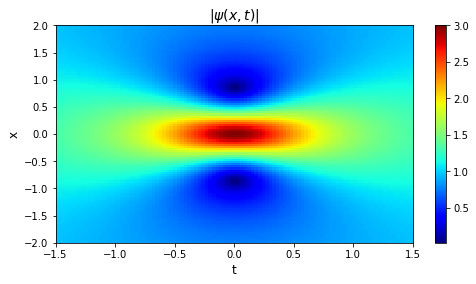

In [ ]:
draw_map(h, [lb[1], ub[1], lb[0], ub[0]],'$ |\psi(x,t)| $')

In [ ]:
lb = np.array([x.min(), t.min()])
ub = np.array([x.max(), t.max()])

N0 = 100
N_b = 100
N_f = 10000 #15000
layers = [2, 100, 100, 100, 100, 2]

t = t.flatten()[:,None]
x = x.flatten()[:,None]

Exact_u = u.T
Exact_v = v.T
Exact_h = np.sqrt(Exact_u**2 + Exact_v**2)

In [ ]:
X, T = np.meshgrid(x,t)
    
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact_u.T.flatten()[:,None]
v_star = Exact_v.T.flatten()[:,None]
h_star = Exact_h.T.flatten()[:,None]
    
idx_x = np.random.choice(x.shape[0], N0, replace=False)
x0 = x[idx_x]
u0 = Exact_u[idx_x,0:1]
v0 = Exact_v[idx_x,0:1]
    
idx_t = np.random.choice(t.shape[0], N_b, replace=False)
tb = t[idx_t]

# Training

In [ ]:
model = PhysicsInformedNN(x0, u0, v0, tb, X_f, layers, lb, ub, 0.0)

In [ ]:
start_time = time.time()          
model.train() # 10k adam + lbfgs
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))

u, v = model.predict(X_star)

Iter 500, Loss: 7.39751e-02, Loss_u: 5.01152e-02, Loss_f: 2.38598e-02
Iter 1000, Loss: 3.97823e-02, Loss_u: 1.96995e-02, Loss_f: 2.00828e-02
Iter 1500, Loss: 2.77990e-02, Loss_u: 1.18328e-02, Loss_f: 1.59662e-02
Iter 2000, Loss: 2.33710e-02, Loss_u: 8.88852e-03, Loss_f: 1.44824e-02
Iter 2500, Loss: 2.13892e-02, Loss_u: 7.85637e-03, Loss_f: 1.35329e-02
Iter 3000, Loss: 2.03166e-02, Loss_u: 7.81043e-03, Loss_f: 1.25061e-02
Iter 3500, Loss: 1.90929e-02, Loss_u: 6.86033e-03, Loss_f: 1.22325e-02
Iter 4000, Loss: 1.79211e-02, Loss_u: 6.77684e-03, Loss_f: 1.11442e-02
Iter 4500, Loss: 1.69010e-02, Loss_u: 6.29760e-03, Loss_f: 1.06034e-02
Iter 5000, Loss: 1.59291e-02, Loss_u: 5.87568e-03, Loss_f: 1.00534e-02
Iter 5500, Loss: 1.50244e-02, Loss_u: 5.46378e-03, Loss_f: 9.56065e-03
Iter 6000, Loss: 1.41899e-02, Loss_u: 5.04103e-03, Loss_f: 9.14883e-03
Iter 6500, Loss: 1.40768e-02, Loss_u: 5.08543e-03, Loss_f: 8.99134e-03
Iter 7000, Loss: 1.25631e-02, Loss_u: 4.35537e-03, Loss_f: 8.20778e-03
Iter 75

In [ ]:
u = u.flatten() 
v = v.flatten()
h = np.sqrt(u**2 + v**2)
u_star = u_star.flatten() 
v_star = v_star.flatten()
h_star = h_star.flatten()

In [ ]:
error_u = np.linalg.norm(u_star-u,2)/np.linalg.norm(u_star,2)
error_v = np.linalg.norm(v_star-v,2)/np.linalg.norm(v_star,2)
error_h = np.linalg.norm(h_star-h,2)/np.linalg.norm(h_star,2)
print('Error u: %e' % (error_u))
print('Error v: %e' % (error_v))
print('Error h: %e' % (error_h))

Error u: 1.328843e+00
Error v: 1.787965e+00
Error h: 3.622678e-01


In [ ]:
u, v = model.predict(X_star)

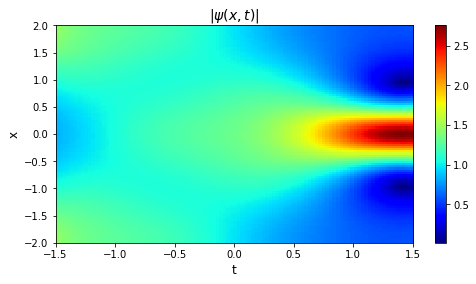

In [ ]:
h = np.sqrt(u**2 + v**2)
h_1 = h.reshape((t.shape[0],x.shape[0]))
h_2 = h_star.reshape((t.shape[0],x.shape[0]))
draw_map(h_1, [lb[1], ub[1], lb[0], ub[0]], '$ |\psi(x,t)| $')